# Time Series Classification

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from tslearn.utils import to_time_series_dataset, save_time_series_txt, load_time_series_txt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import pickle

In [2]:
data_path = '/home/mattiapggioli/lyrics2ts/data/classification/pp-rc/sbert/'
truncate=100
max_iter = 2000
paa_window_size = None
undersampling = None

In [3]:
# Parameters
data_path = "/home/mattiapggioli/lyrics2ts/data/classification/pp-rc-rp/features/"
paa_window_size = 20
undersampling = 0.3


In [4]:
ts = load_time_series_txt(f'{data_path}/ts.txt')

In [5]:
ts.shape

(36000, 130, 1)

In [6]:
with open(f'{data_path}/y_class.npy', 'rb') as f:
    y = np.load(f, allow_pickle=True)

In [7]:
with open(f'{data_path}/X.npy', 'rb') as f:
    X = np.load(f, allow_pickle=True)

In [8]:
X.shape

(36000, 14)

In [9]:
set(y)

{'pop', 'rap', 'rock'}

In [10]:
ts_train, ts_test, y_train, y_test = train_test_split(
    ts, y, test_size=0.20, random_state=42, stratify=y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

In [12]:
random.choice(ts_train)

array([[-0.59580353],
       [-0.52012664],
       [-1.87462517],
       [-0.52012664],
       [-1.55649302],
       [-3.77304885],
       [-4.58697466],
       [-2.42502552],
       [-3.0783067 ],
       [ 0.08052177],
       [ 0.52959275],
       [-1.9167334 ],
       [-0.32397087],
       [-1.19037543],
       [-3.33451992],
       [-2.37032096],
       [-3.7336274 ],
       [-0.08652163],
       [ 0.25383976],
       [-2.28890758],
       [-1.8155027 ],
       [ 0.60454703],
       [-1.66457474],
       [ 2.56662838],
       [-1.37251414],
       [ 0.69458793],
       [-3.78117528],
       [-1.80227495],
       [-3.7336274 ],
       [ 0.28413546],
       [ 1.20346219],
       [-2.28890758],
       [-0.61546519],
       [-2.33304645],
       [-2.16396398],
       [-0.13220873],
       [-0.02247056],
       [ 0.51859521],
       [-3.95642806],
       [-1.55478788],
       [ 0.97400175],
       [ 1.92627328],
       [ 3.37183127],
       [-0.52012664],
       [-0.34714051],
       [ 3

<AxesSubplot:ylabel='Count'>

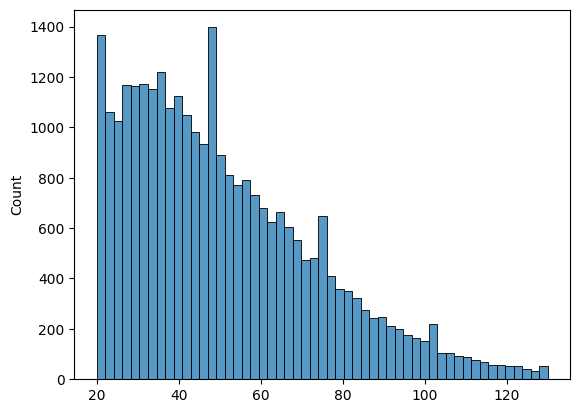

In [13]:
sns.histplot([t[~np.any(np.isnan(t), axis=1)].shape[0] for t in ts_train])

In [14]:
ts_train = ts_train[:, :truncate, :]
ts_test = ts_test[:, :truncate, :]

In [15]:
mean_arr = np.nanmean(ts_train, axis=1, keepdims=True)
nan_indices = np.isnan(ts_train)
ts_train[nan_indices] = np.take(mean_arr, np.nonzero(nan_indices)[0])

mean_arr = np.nanmean(ts_test, axis=1, keepdims=True)
nan_indices = np.isnan(ts_test)
ts_test[nan_indices] = np.take(mean_arr, np.nonzero(nan_indices)[0])

In [16]:
np.count_nonzero(np.isnan(X_train))

0

In [17]:
X_train[np.isnan(X_train)] = 0
X_test[np.isnan(X_test)] = 0

In [18]:
save_time_series_txt(f'{data_path}/ts_train.txt', ts_train)
save_time_series_txt(f'{data_path}/ts_test.txt', ts_test)

In [19]:
with open(f'{data_path}/X_train.npy', 'wb') as f:
    np.save(f, X_train, allow_pickle=True)

with open(f'{data_path}/X_test.npy', 'wb') as f:
    np.save(f, X_test, allow_pickle=True)

In [20]:
with open(f'{data_path}/y_train.npy', 'wb') as f:
    np.save(f, y_train, allow_pickle=True)

with open(f'{data_path}/y_test.npy', 'wb') as f:
    np.save(f, y_test, allow_pickle=True)

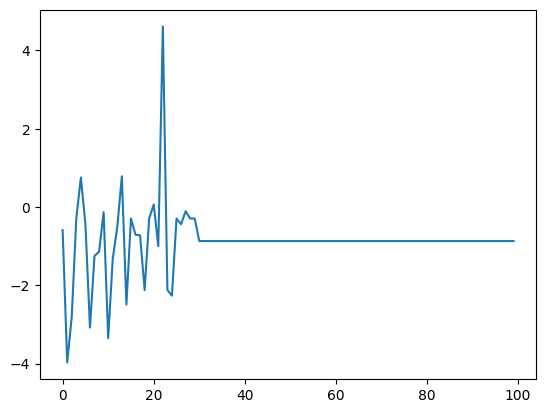

In [21]:
plt.plot(random.choice(ts_train))

In [22]:
# Parameters that require knowing if it's binary or multiclass (LightGBM, metrics)
if len(set(y)) == 2:
    avg_par = 'macro'
    obj_par = 'binary'
elif len(set(y)) > 2:
    avg_par = 'weighted'
    obj_par = 'multiclass'

## Classification

In [23]:
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier

In [24]:
metrics_data = {}

### Baseline: global features (No Time Series)

In [25]:
metrics_data['Global'] = {}

**Decision Tree**

In [26]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [27]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         pop       0.48      0.47      0.48      2400
         rap       0.79      0.79      0.79      2400
        rock       0.51      0.52      0.51      2400

    accuracy                           0.59      7200
   macro avg       0.59      0.59      0.59      7200
weighted avg       0.59      0.59      0.59      7200



In [28]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Global']['DecisionTree'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**Random Forest**

In [29]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         pop       0.59      0.56      0.57      2400
         rap       0.88      0.85      0.86      2400
        rock       0.60      0.65      0.62      2400

    accuracy                           0.68      7200
   macro avg       0.69      0.68      0.69      7200
weighted avg       0.69      0.68      0.69      7200



In [31]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Global']['RandomForest'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**LightGBM**

In [32]:
clf = lgbm.LGBMClassifier(objective=obj_par) 
clf.fit(X_train, y_train)

LGBMClassifier(objective='multiclass')

In [33]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         pop       0.59      0.55      0.57      2400
         rap       0.88      0.85      0.87      2400
        rock       0.60      0.65      0.62      2400

    accuracy                           0.69      7200
   macro avg       0.69      0.69      0.69      7200
weighted avg       0.69      0.69      0.69      7200



In [34]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Global']['LightGBM'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

### Time Series Classification

#### Learning Shapelets

In [35]:
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict

2023-03-21 03:31:07.342239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 03:31:07.621172: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-21 03:31:07.621196: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2023-03-21 03:31:08.406966: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-21 03:31:08.407063: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-21 03:31:08.407072: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [36]:
n_ts, ts_sz, _ = ts_train.shape
n_classes = len(set(y_train))

In [37]:
# Set the number of shapelets per size as done in the original paper
g_shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                         ts_sz=ts_sz,
                                                         n_classes=n_classes,
                                                         l=0.1,
                                                         r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', g_shapelet_sizes)

n_ts 28800
ts_sz 100
n_classes 3
shapelet_sizes {10: 6}


In [38]:
shapelet_sizes = {}
for key in g_shapelet_sizes:
    shapelet_sizes[key] = g_shapelet_sizes[key]
    shapelet_sizes[key*2] = g_shapelet_sizes[key]
    shapelet_sizes[key//2] = g_shapelet_sizes[key]
shapelet_sizes

{10: 6, 20: 6, 5: 6}

In [39]:
model = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                          optimizer="adam", 
                          weight_regularizer=.01, 
                          max_iter=max_iter, verbose=0, random_state=42)

/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [40]:
%%time
model.fit(ts_train, y_train)

2023-03-21 03:31:10.418437: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-21 03:31:10.418465: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-21 03:31:10.418484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mattiapggioli-ThinkPad-E595): /proc/driver/nvidia/version does not exist
2023-03-21 03:31:10.418692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 3h 52min 50s, sys: 12min 53s, total: 4h 5min 44s
Wall time: 40min 20s


LearningShapelets(max_iter=2000, n_shapelets_per_size={5: 6, 10: 6, 20: 6},
                  optimizer='adam', random_state=42, weight_regularizer=0.01)

In [41]:
model.to_pickle(f'{data_path}/shapelets.pkl')

#### Shapelet-Based Classification

In [42]:
metrics_data['Shapelets'] = {}

In [43]:
X_train = model.transform(ts_train)
X_test = model.transform(ts_test)

In [44]:
pd.DataFrame(X_test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,7.746901,9.910121,0.587465,12.396136,0.601946,10.715814,2.504696,0.284763,7.143951,5.902871,0.908627,1.619079,1.075165,0.133815,11.071413,0.621512,0.137794,0.156082
1,9.508211,7.193626,0.164815,7.456922,3.429113,6.277751,4.229818,1.226454,4.228686,4.422422,0.369627,3.049556,0.482311,0.614214,8.174726,1.734490,0.626280,0.669156
2,2.291618,22.697670,2.175556,13.928302,0.182315,11.041733,1.457235,0.830684,9.104367,13.589728,4.838540,2.203039,6.657222,2.222235,19.479208,0.771595,2.200938,2.088305
3,4.169612,7.041772,0.963977,6.823640,2.463652,9.254683,3.670389,0.292228,5.065772,9.391532,1.561265,2.568665,1.766487,0.027967,13.492350,0.387798,0.027286,0.021434
4,2.436801,15.069315,0.903810,11.257213,0.395388,12.190153,1.994109,0.043579,5.747569,7.336812,2.418043,1.559480,3.026695,0.230230,13.626838,0.046899,0.223364,0.185477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7195,2.788623,7.898487,0.065021,7.682107,2.203157,12.969172,4.085660,0.760098,6.250420,3.990648,0.774866,2.195870,1.052316,0.142591,6.651444,0.927936,0.146756,0.166001
7196,8.994727,8.241096,0.118973,16.844995,1.689758,11.735747,5.170124,2.050570,8.131988,3.192145,0.300770,4.242809,0.399660,0.852372,9.015173,2.337209,0.864501,0.925003
7197,2.595163,10.092140,0.818493,9.535891,0.387199,10.278941,1.381214,0.044754,6.170273,6.515965,1.190675,1.277071,1.952957,0.222139,11.460181,0.049971,0.215400,0.178171
7198,5.528160,7.938399,0.139747,7.379004,0.596717,10.074095,1.892190,0.408371,3.622979,4.951965,0.822418,1.721339,2.115578,1.001705,10.819368,1.142763,1.004142,0.997727


**Decision Tree**

In [45]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [46]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         pop       0.40      0.40      0.40      2400
         rap       0.69      0.67      0.68      2400
        rock       0.48      0.48      0.48      2400

    accuracy                           0.52      7200
   macro avg       0.52      0.52      0.52      7200
weighted avg       0.52      0.52      0.52      7200



In [47]:
pickle.dump(clf, open(f'{data_path}/decision_tree.pkl', 'wb'))

In [48]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Shapelets']['DecisionTree'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**Random Forest**

In [49]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [50]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         pop       0.48      0.42      0.45      2400
         rap       0.77      0.80      0.78      2400
        rock       0.55      0.60      0.58      2400

    accuracy                           0.61      7200
   macro avg       0.60      0.61      0.60      7200
weighted avg       0.60      0.61      0.60      7200



In [51]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Shapelets']['RandomForest'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**LightGBM**

In [52]:
clf = lgbm.LGBMClassifier(objective=obj_par) 
clf.fit(X_train, y_train)

LGBMClassifier(objective='multiclass')

In [53]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         pop       0.48      0.39      0.43      2400
         rap       0.77      0.79      0.78      2400
        rock       0.55      0.64      0.59      2400

    accuracy                           0.61      7200
   macro avg       0.60      0.61      0.60      7200
weighted avg       0.60      0.61      0.60      7200



In [54]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Shapelets']['LightGBM'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

#### KNN

In [55]:
X_train = ts_train.reshape((ts_train.shape[0], ts_train.shape[1]))
X_test = ts_test.reshape((ts_test.shape[0], ts_test.shape[1]))

In [56]:
X_train.shape

(28800, 100)

In [57]:
metrics_data['KNN'] = {}

**Euclidean Distance**

In [58]:
from sklearn.neighbors import KNeighborsClassifier

In [59]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [60]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         pop       0.33      0.31      0.32      2400
         rap       0.82      0.12      0.21      2400
        rock       0.38      0.72      0.49      2400

    accuracy                           0.38      7200
   macro avg       0.51      0.38      0.34      7200
weighted avg       0.51      0.38      0.34      7200



In [61]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['KNN']['Euclidean'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**Dynamic Time Warping**

In [62]:
from pyts.classification import KNeighborsClassifier
from pyts.approximation import PiecewiseAggregateApproximation
from imblearn.under_sampling import ClusterCentroids
from sklearn_extra.cluster import KMedoids

In [63]:
if paa_window_size:
    paa = PiecewiseAggregateApproximation(window_size=paa_window_size)
    X_train = paa.transform(X_train)
    X_test = paa.transform(X_test)
    X_train.shape

In [64]:
if undersampling:
    total_samples = len(y_train)
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    samp_strat = dict(zip(unique_classes, np.floor(class_counts * undersampling).astype(int)))
    print(samp_strat)
    cc = ClusterCentroids(estimator=KMedoids(
        random_state=42), sampling_strategy=samp_strat, random_state=42)
    X_train, y_train = cc.fit_resample(X_train, y_train)
    X_train.shape

{'pop': 2880, 'rap': 2880, 'rock': 2880}


/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 1169 is empty! self.labels_[self.medoid_indices_[1169]] may not be labeled with its corresponding cluster (1169).
  warnings.warn(
/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 1414 is empty! self.labels_[self.medoid_indices_[1414]] may not be labeled with its corresponding cluster (1414).
  warnings.warn(


/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 699 is empty! self.labels_[self.medoid_indices_[699]] may not be labeled with its corresponding cluster (699).
  warnings.warn(
/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 743 is empty! self.labels_[self.medoid_indices_[743]] may not be labeled with its corresponding cluster (743).
  warnings.warn(
/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 952 is empty! self.labels_[self.medoid_indices_[952]] may not be labeled with its corresponding cluster (952).
  warnings.warn(
/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/sklearn_extra/cluster/_k_medoids.py:275: UserWarning: Cluster 1258 is empty! self.labels_[self.medoid_indices_[1258]] may not be labeled with its corresponding cluster (1258)

In [65]:
clf = KNeighborsClassifier(metric='dtw_sakoechiba',  metric_params={'window_size':3})

clf.fit(X_train, y_train)

KNeighborsClassifier(metric='dtw_sakoechiba', metric_params={'window_size': 3})

In [66]:
%%time
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         pop       0.43      0.32      0.37      2400
         rap       0.57      0.71      0.63      2400
        rock       0.49      0.49      0.49      2400

    accuracy                           0.51      7200
   macro avg       0.50      0.51      0.50      7200
weighted avg       0.50      0.51      0.50      7200

CPU times: user 2h 45min 28s, sys: 747 ms, total: 2h 45min 29s
Wall time: 2h 45min 28s


In [67]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['KNN']['DTW'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

## Overall Results

In [68]:
metrics_data = pd.DataFrame.from_dict({(i,j): metrics_data[i][j] 
                                       for i in metrics_data.keys() 
                                       for j in metrics_data[i].keys()},
                                       orient='index')

In [69]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

In [70]:
metrics_data

Accuracy  Precision    Recall        F1
Global    DecisionTree  0.592917   0.592348  0.592917  0.592591
          RandomForest  0.684722   0.687810  0.684722  0.685791
          LightGBM      0.685139   0.688802  0.685139  0.686252
Shapelets DecisionTree  0.518472   0.519979  0.518472  0.519186
          RandomForest  0.605833   0.599908  0.605833  0.601786
          LightGBM      0.606806   0.600792  0.606806  0.601135
KNN       Euclidean     0.383056   0.509532  0.383056  0.340918
          DTW           0.507778   0.495840  0.507778  0.496631

In [71]:
metrics_data.to_csv(f'{data_path}/metrics.csv')